# Lab 3 Draft Report: How Are Increasing Incarceration Rates Associated with Crime Rate?

Katie Mo, Errett Hobbs, and Ramiro Cadavid

## (1) Introduction

It's easy for candidates to support the idea of throwing criminals into prison to appear tough on crime; however, do available data support this position? Is incarceration associated with crime rate in North Carolina? If yes, then how so? To investigate these questions, we constructed a model that predicts crime rate ($crmrte$) as a function of the probability of getting arrested ($prbarr$), the probability of becoming convicted after arrest ($prbconv$), and the probability of becoming incarcerated upon conviction ($prbpris$). 

Incarceration is very costly; if it is not associated with lower crime rates, then the state of North Carolina should explore less costly alternatives. On average, incarceration costs the state of North Carolina \\$36,219 per inmate per year, whereas prison alternatives like probation or parole supervision cost less than \$5,000 per year<sup>1</sup>. The number of people imprisoned in America has increased from roughly 500,000 to over 2.2 million, more than four fold, between 1980 to 2015<sup>2</sup>.  

Our analysis indicates that the likelihood of arrests and convictions are both associated with lower crime rate, while the likelihood of incarcerations does not show any strong association. These findings suggest that using the money saved from reduced incarceration of less serious crimes to fund pilot programs to improve criminal justice processing procedures could be beneficial for reducing crime rate in North Carolina.

## (2) Exploratory Data Analysis

### Import libraries and dataset

In [180]:
install.packages("corrplot")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [181]:
options(warn = -1)
library(dplyr)
library(corrplot)
library(car)
library(stargazer)
library(lmtest)
library(sandwich)
crime <- read.csv('crime_v2.csv')

### Data cleaning and univariate analysis

#### First stage

The campaign research questions will be assessed using a dataset of crime statistics that contain 91 out of 100 counties in North Carolina. Even though it contains most of the counties in the state, we do not have information on the sampling regime used to select the counties in this dataset and cannot assume that the sample is random. This implies that we cannot  treat our findings as representative of our population of all the counties but only of those contained in the sample. However, the fact that there is data for 90% of counties make our findings relevant for most of the target counties of the political campaign.

A high level assessment of the dataset reveals that all but one (`probability of prison`) of the variables are numerical/integer variables and all of them but have one (again, `probability of prison`) have 6 blank observations. We need to investigate later if they belong to the same six observations. Other important features to notice are that:

- `year` is useful to provide context to results but it is not relevant since it doesn't contain any variation.
- `probability of arrest` has at least one value larger than 1 that needs to be further investigated.
- `probability of conviction` is a factor when it should be an integer. It has at least one non-numerical value (\`) which is the likely cause of why it was imported as a class factor.
- The values of `density` seem to be unusually low. We need to further investigate the reason for these unusually small values.
- We are unclear as to how `west` and `central` are each defined; we also do not know if they are exhaustive of all counties and mutually exclusive. 
- The definition of `urban` according to whether the county is categorized as a standard metropolitan statistical area (SMSA) is ambiguous for our purposes. According to the US Census, a SMSA is "a geographic entity defined by the federal Office of Management and Budget for use by federal statistical agencies". Furthermore, according to the Wikipedia entry of this kind of entity "such regions are neither legally incorporated as a city or town would be, nor are they legal administrative divisions like counties or separate entities such as states; because of this, the precise definition of any given metropolitan area can vary with the source". Therefore, incorporating this variable into our model would not let give us information about either the relationship that is being modeled or the factors that are being controlled for.
- `mix`is also ambiguously defined since it is not clear what face-to-face offences mean and it is also not clear how some of the plausible interpretations of this variable could be of interest to solve our research question.

All the other variables not mentioned above seem to be within reasonable ranges and do not have unusually high concentration of values. In the second stage, we take a closer look at some of these given their importance to answer the campaign's research question.

In [182]:
paste("Number of unique counties:", length(unique(crime$county)))

[1] "Number of unique counties: 91"

In [183]:
paste("Structure of dataset")
str(crime)

[1] "Structure of dataset"

'data.frame':	97 obs. of  25 variables:
 $ county  : int  1 3 5 7 9 11 13 15 17 19 ...
 $ year    : int  87 87 87 87 87 87 87 87 87 87 ...
 $ crmrte  : num  0.0356 0.0153 0.013 0.0268 0.0106 ...
 $ prbarr  : num  0.298 0.132 0.444 0.365 0.518 ...
 $ prbconv : Factor w/ 92 levels "","`","0.068376102",..: 63 89 13 62 52 3 59 78 42 86 ...
 $ prbpris : num  0.436 0.45 0.6 0.435 0.443 ...
 $ avgsen  : num  6.71 6.35 6.76 7.14 8.22 ...
 $ polpc   : num  0.001828 0.000746 0.001234 0.00153 0.00086 ...
 $ density : num  2.423 1.046 0.413 0.492 0.547 ...
 $ taxpc   : num  31 26.9 34.8 42.9 28.1 ...
 $ west    : int  0 0 1 0 1 1 0 0 0 0 ...
 $ central : int  1 1 0 1 0 0 0 0 0 0 ...
 $ urban   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ pctmin80: num  20.22 7.92 3.16 47.92 1.8 ...
 $ wcon    : num  281 255 227 375 292 ...
 $ wtuc    : num  409 376 372 398 377 ...
 $ wtrd    : num  221 196 229 191 207 ...
 $ wfir    : num  453 259 306 281 289 ...
 $ wser    : num  274 192 210 257 215 ...
 $ wmfg    : num  33

In [184]:
paste("Summary statistics of variables in dataset")
summary(crime)

[1] "Summary statistics of variables in dataset"

     county           year        crmrte             prbarr       
 Min.   :  1.0   Min.   :87   Min.   :0.005533   Min.   :0.09277  
 1st Qu.: 52.0   1st Qu.:87   1st Qu.:0.020927   1st Qu.:0.20568  
 Median :105.0   Median :87   Median :0.029986   Median :0.27095  
 Mean   :101.6   Mean   :87   Mean   :0.033400   Mean   :0.29492  
 3rd Qu.:152.0   3rd Qu.:87   3rd Qu.:0.039642   3rd Qu.:0.34438  
 Max.   :197.0   Max.   :87   Max.   :0.098966   Max.   :1.09091  
 NA's   :6       NA's   :6    NA's   :6          NA's   :6        
        prbconv      prbpris           avgsen           polpc         
            : 5   Min.   :0.1500   Min.   : 5.380   Min.   :0.000746  
 0.588859022: 2   1st Qu.:0.3648   1st Qu.: 7.340   1st Qu.:0.001231  
 `          : 1   Median :0.4234   Median : 9.100   Median :0.001485  
 0.068376102: 1   Mean   :0.4108   Mean   : 9.647   Mean   :0.001702  
 0.140350997: 1   3rd Qu.:0.4568   3rd Qu.:11.420   3rd Qu.:0.001877  
 0.154451996: 1   Max.   :0.6000   Max

Upon closer inspection of incomplete cases, we found that indeed the six blank values for all the variables but `prbconv` come from the same six observations. Furthermore, the value '\`' included in `prbconv` comes from one of these observations. In this case, given that these values do not add any information to our dataset and that one of their values is causing `probability of conviction` to be casted with the wrong class, we have decided to remove them from the dataset.

In [185]:
paste("Empty cases:")
options(repr.matrix.max.rows=10,repr.matrix.max.cols=200)
crime[!complete.cases(crime), ]

[1] "Empty cases:"

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,west,central,urban,pctmin80,wcon,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
92,NA,NA,NA,NA,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
93,NA,NA,NA,NA,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
94,NA,NA,NA,NA,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
95,NA,NA,NA,NA,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
96,NA,NA,NA,NA,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
97,NA,NA,NA,NA,`,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [186]:
# Remove empty cases
clean <- crime[complete.cases(crime), ]

#### Second stage

Following the superficial analysis of the dataset, we proceed to dig deeper into the possible quality issues found and to explore the main features of our variables of interest and control variables. To do this, our approach is to try to identify sources of errors (exploring atypical values, finding unusual concentrations of observations around certain values), and using dispersion measurements and plots to identify particular features in the distribution of these variables that may be useful to better model the relationships of interest to the campaign. 

In this stage, we focused only on the variables that are of interest to the campaign and variables that may be useful controls to include in our regression analysis.

#### Variables of interest

##### County

We found two observations with the same `county` value (county 193). Upon closer inspection, we found that both observations contain the exact same data. Consequently, we removed one of these duplicate observations.

In [187]:
# One duplicated county (remove)
paste("Unique county identifier:", nrow(clean) == length(unique(clean$county)))
paste("Duplicated county id:", clean$county[duplicated(clean$county) & !is.na(clean$county)])
subset(clean, subset = clean$county == 193)
clean <- clean[!duplicated(clean$county), ]

[1] "Unique county identifier: FALSE"

[1] "Duplicated county id: 193"

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,west,central,urban,pctmin80,wcon,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
88,193,87,0.0235277,0.266055,0.588859022,0.423423,5.86,0.00117887,0.8138298,28.51783,1,0,0,5.93109,285.8289,480.1948,268.3836,365.0196,295.9352,295.63,468.26,337.88,348.74,0.1105016,0.07819394
89,193,87,0.0235277,0.266055,0.588859022,0.423423,5.86,0.00117887,0.8138298,28.51783,1,0,0,5.93109,285.8289,480.1948,268.3836,365.0196,295.9352,295.63,468.26,337.88,348.74,0.1105016,0.07819394


##### Crime rate

`crime rate` values are within a reasonable range and there are no concentrations around specific values that would lead us to suspect measurement errors. Therefore, we will leave it unchanged.

In [188]:
summary(clean$crmrte)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.005533 0.020604 0.030002 0.033510 0.040249 0.098966 

The distribution of `crmrte` is positively skewed. However, taking the natural logarithm of `crmrte` resolves this skewness and makes the distribution adopt a more normal appearance. Therefore, we will explore including this transformation in follow up analyses. Moreover, the number of observations (90) is sufficiently large that we can invoke the Central Limit Theorem (CLT) when evaluating linear model assumptions.

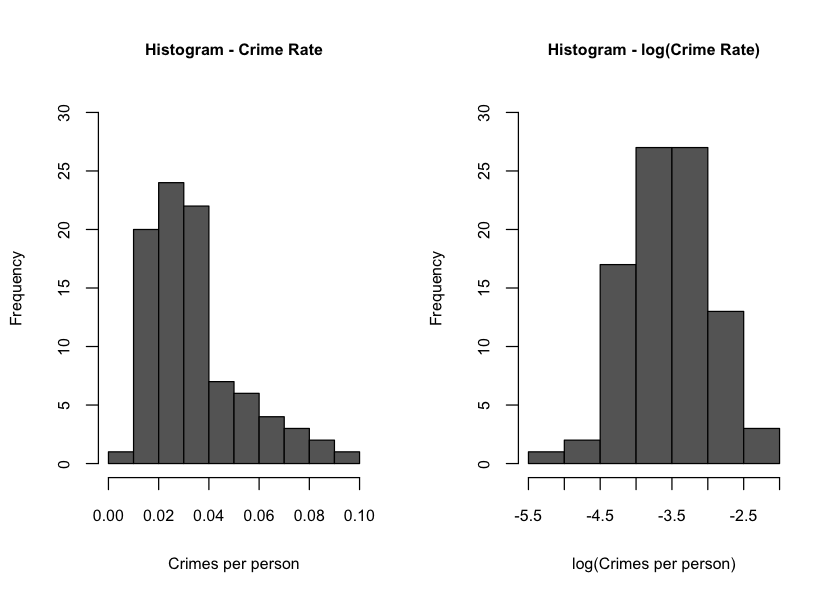

In [189]:
par(mfrow = c(1, 2), cex.main = 0.8, cex.lab = 0.8, cex.axis = 0.8)
options(repr.plot.width=7, repr.plot.height=5)
hist(clean$crmrte, main = "Histogram - Crime Rate", col = rgb(0.4, 0.4, 0.4, 1), ylim = c(0, 30), xlab = "Crimes per person",
     breaks = sqrt(nrow(clean)))
hist(log(clean$crmrte), main = "Histogram - log(Crime Rate)", col = rgb(0.4, 0.4, 0.4, 1), ylim = c(0, 30), 
     xlab = "log(Crimes per person)", breaks = sqrt(nrow(clean)))

In [190]:
# Check for concentration of values
freqs.crmrte <- data.frame(table(clean$crmrte))
paste("Repeated values:", 
      length(freqs.crmrte$Freq[freqs.crmrte$Freq > 1]))

[1] "Repeated values: 0"

##### Probability of arrest

There is one value higher than 1. This is atypical but we cannot be sure that it is a error since we don't have enough information about how this variable is defined. Specifically, there are possible definitions of this variable or county characteristics under which a value higher than 1 is possible. For example, if `probability of arrest` is defined as,

$$prbarr = \frac{\text{arrests_in_period_t}}{\text{crimes_in_period_t}}$$.

Under this definition, arrests in period t correspond both to crimes committed in period $t$ but also in $t-i$ since there is a lag between the time when a crime is committed and the time when the arrest is made, that could span for more than one period. For example, it is possible that after a period $t-1$ with an unusually high number of crimes followed by a period $t$ with unusually low number of crimes the number of arrests in $t$ is higher than the number of crimes in $t$, since many of the arrests in $t$ may come from the crimes committed in $t-1$.

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,west,central,urban,pctmin80,wcon,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
51,115,87,0.0055332,1.09091,1.5,0.5,20.7,0.00905433,0.3858093,28.1931,1,0,0,1.28365,204.2206,503.2351,217.4908,342.4658,245.2061,448.42,442.2,340.39,386.12,0.1,0.07253495


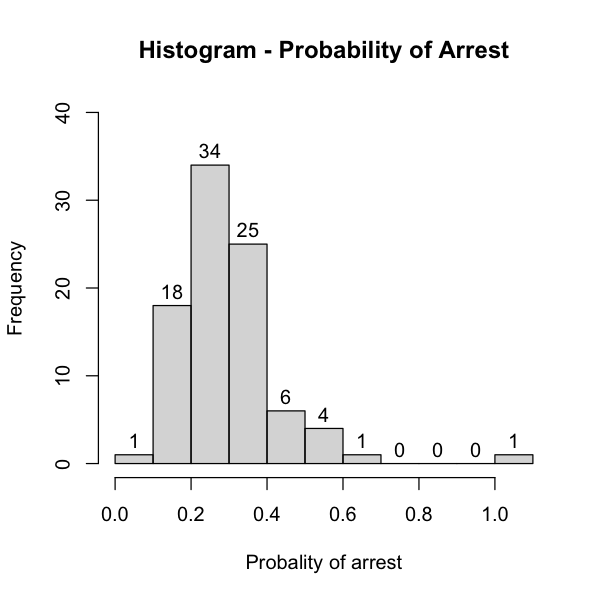

In [191]:
options(repr.plot.width=5, repr.plot.height=5)
hist(clean$prbarr, main = "Histogram - Probability of Arrest", xlab = "Probality of arrest", 
     labels = TRUE, ylim = c(0, 40), col = rgb(0.5, 0.5, 0.5, 0.3))
clean[clean$prbarr > 1, ]

##### Probability of conviction

`prbconv` is being imported into R as a factor, when it should be numeric, which is likely caused by the '\`' value. Since we have removed this value already, we can now recast this variable as as numeric.

In [192]:
# Remove ` and cast the column to numeric
clean$prbconv <- as.numeric(as.character(clean$prbconv))

Summarizing this variable, we found that there are 10 observations with values higher than 1 and one of them with a value higher than 2. Despite these values being unusually high they are possible for the same reasons exposed in the case of `prbarr`. Furthermore, in the case of `prbconv`, the lag between the arrest and the end of a trial could be even longer than the lag of `prbarr`. Therefore, since we don't have additional information on the definition used to build this variable and no way to validate which specific definition was used using numerical methods, we will not clean these 10 values.

In [193]:
paste("Summary statistics - Probability of conviction")
summary(clean$prbconv)
paste("Number of observations higher than 1:", length(clean$prbconv[clean$prbconv > 1]))
clean[clean$prbconv > 1, ]

[1] "Summary statistics - Probability of conviction"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06838 0.34422 0.45170 0.55086 0.58513 2.12121 

[1] "Number of observations higher than 1: 10"

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,west,central,urban,pctmin80,wcon,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
2,3,87,0.0152532,0.132029,1.48148,0.450000,6.35,0.00074588,1.0463320,26.89208,0,1,0,7.91632,255.1020,376.2542,196.0101,258.5650,192.3077,300.38,409.83,362.96,301.47,0.03022670,0.08260694
10,19,87,0.0221567,0.162860,1.22561,0.333333,10.34,0.00202425,0.5767442,61.15251,0,0,0,24.31170,260.1381,613.2261,191.2452,290.5141,266.0934,567.06,403.15,258.33,299.44,0.05334728,0.07713232
44,99,87,0.0171865,0.153846,1.23438,0.556962,14.75,0.00185912,0.5478615,39.57348,1,0,0,14.28460,259.7841,417.2099,168.2692,301.5734,247.6291,258.99,442.76,387.02,291.44,0.01960784,0.12894706
51,115,87,0.0055332,1.090910,1.50000,0.500000,20.70,0.00905433,0.3858093,28.19310,1,0,0,1.28365,204.2206,503.2351,217.4908,342.4658,245.2061,448.42,442.20,340.39,386.12,0.10000000,0.07253495
56,127,87,0.0291496,0.179616,1.35814,0.335616,15.99,0.00158289,1.3388889,32.02376,0,0,0,34.27990,290.9091,426.3901,257.6008,441.1413,305.7612,329.87,508.61,380.30,329.71,0.06305506,0.07400288
61,137,87,0.0126662,0.207143,1.06897,0.322581,6.18,0.00081426,0.3167155,44.29367,0,0,0,33.04480,299.4956,356.1254,170.8711,170.9402,250.8361,192.96,360.84,283.90,321.73,0.06870229,0.07098370
67,149,87,0.0164987,0.271967,1.01538,0.227273,14.62,0.00151871,0.6092437,29.03402,1,0,0,10.00460,223.6136,437.0629,188.7683,353.2182,210.4415,289.43,421.34,342.92,301.23,0.11682243,0.06215772
84,185,87,0.0108703,0.195266,2.12121,0.442857,5.38,0.00122210,0.3887588,40.82454,0,1,0,64.34820,226.8245,331.5650,167.3726,264.4231,2177.0681,247.72,381.33,367.25,300.13,0.04968944,0.07008217
90,195,87,0.0313973,0.201397,1.67052,0.470588,13.02,0.00445923,1.7459893,53.66693,0,0,0,37.43110,315.1641,377.9356,246.0614,411.4330,296.8684,392.27,480.79,303.11,337.28,0.15612382,0.07945071
91,197,87,0.0141928,0.207595,1.18293,0.360825,12.23,0.00118573,0.8898810,25.95258,1,0,0,5.46081,314.1660,341.8803,182.8020,348.1432,212.8205,322.92,391.72,385.65,306.85,0.06756757,0.07419893


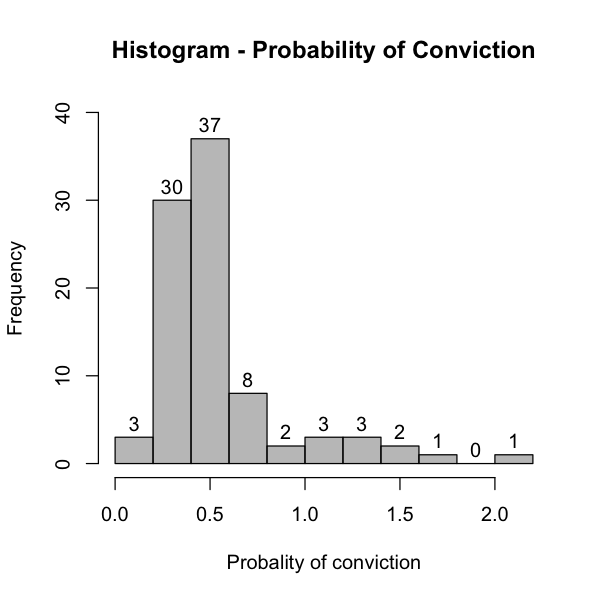

In [194]:
hist(clean$prbconv, main = "Histogram - Probability of Conviction", xlab = "Probality of conviction",
     labels = TRUE, ylim = c(0, 40), col = rgb(0.5, 0.5, 0.5, 0.5))

##### Probability of prison

Probability of prison spreads over a reasonable range (between 0.15 fand 0.6) and does not seem to have unusually high concentrations around certain values that would lead us to suspect measurement errors. Furthermore, the distribution of this variable is symmetric with particular features that we need to take into account when building our model.

It is interesting to note that, unlike probability of arrest and conviction, this variable does not have unusually large values, which further supports our suspicion that the numerator and denominator of these two variables correspond in part to data from different periods, given the existing lag between the time a crime is commited and an arrest is made, and the lag between an arrest and the end of a trial. In contrast, there is usually a small time lag between the time a conviction is made and the sentence is delivered, where misdemeanor cases are usually sentenced immediately and felony cases in days to weeks.

In [195]:
paste("Summary statistics - Probability of prison")
summary(clean$prbpris)

[1] "Summary statistics - Probability of prison"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1500  0.3642  0.4222  0.4106  0.4576  0.6000 

##### Average sentence

The average sentence ranges between 5.3 and 20.7 days, with a mean of 9.7 days. These are all very small numbers which may indicate that this variable is defined as

$$\frac{1}{\text{Number of convictions}}\sum_{i=1}^n{\text{Number of days of prison}}$$

This means that the average is not taken only over the convictions that led to prison sentences, but over all convictions, including many $0$ values where there should be `NA`s.

This definition is problematic for our purposes for two reasons:

1. `avgsen` may have a high collinearity with `prbpris` because a higher probability of prison will likely be associated with higher average sentences. This will obfuscate the difference between these two variables, which are both of interest to the campaign, and will decrease the efficiency of the estimators, making it harder to assess their statistical significance.
2. One of the questions of interest to the campaign is whether higher sentences will lead to lower crime. Given that the majority of sentences do not result in prison time (the probability of being sentenced is 41% on average), the average sentence will be mainly driven all these 0 values and will not provide useful information on the sentences that result in prison.

However, the guiding documentation does not provide a definition of how this variable is calculated, and we don't have other ways to deduce what definition was used. Therefore, we will assume for the moment that the above is the definition that was used and will not transform this variable, since we didn't find evidence of measurement errors, and its distribution doesn't show skewness, atypical values or unusually high concentrations of observations around certain values.

In [196]:
paste("Average probability of prison:", round(100 * mean(clean$prbpris), 1), "%")

[1] "Average probability of prison: 41.1 %"

In [197]:
paste("Summary statistics - Average sentence")
summary(clean$avgsen)

[1] "Summary statistics - Average sentence"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.380   7.375   9.110   9.689  11.465  20.700 

#### Control variables

##### Density

As mentioned above, the values of density look unusually low. Given that the density of North Carolina between 1980 and 1990 ranged from 120.9 to 136.4 [(US Census, 2018)](https://www.census.gov/population/www/censusdata/density.html) and that our sample contains 90% of counties, some of which are categorized as urban, a density of less than 1.6 for 75% of observations and a maximum density of 8.8 seems to be unusually low. Even though the guiding documentation does not provide details on the definition of this variable, it could be the case that this variable is scaled; however, we cannot validate this using our dataset and this wouldn't make a difference in our regression model, since the rescaling would not affect the $R^2$ or significance of the estimated coefficient, only it value. Therefore, this variable is still useful given that it may be used as a control and we are not particularly interested in the value of the estimated coefficient.

In [198]:
paste("Summary statistics - density")
summary(clean$density)

[1] "Summary statistics - density"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00002 0.54718 0.97925 1.43567 1.56926 8.82765 

In [199]:
density.freq <- data.frame(table(clean$density))
paste("Values with unusual concentration of observations:", nrow(density.freq[density.freq$Freq > 1, ]))

[1] "Values with unusual concentration of observations: 0"

##### Other variables

Upon inspecting other variables at a high level, we didn't find evidence of errors or other specially relevant features that needed to be taken into account into the model that we will build to answer our research question. The values in these variables were within reasonable ranges, there were no missing values and there were not unusually high concentrations of observations around certain values. Therefore, all the other variables that were not mentioned above were not transformed.

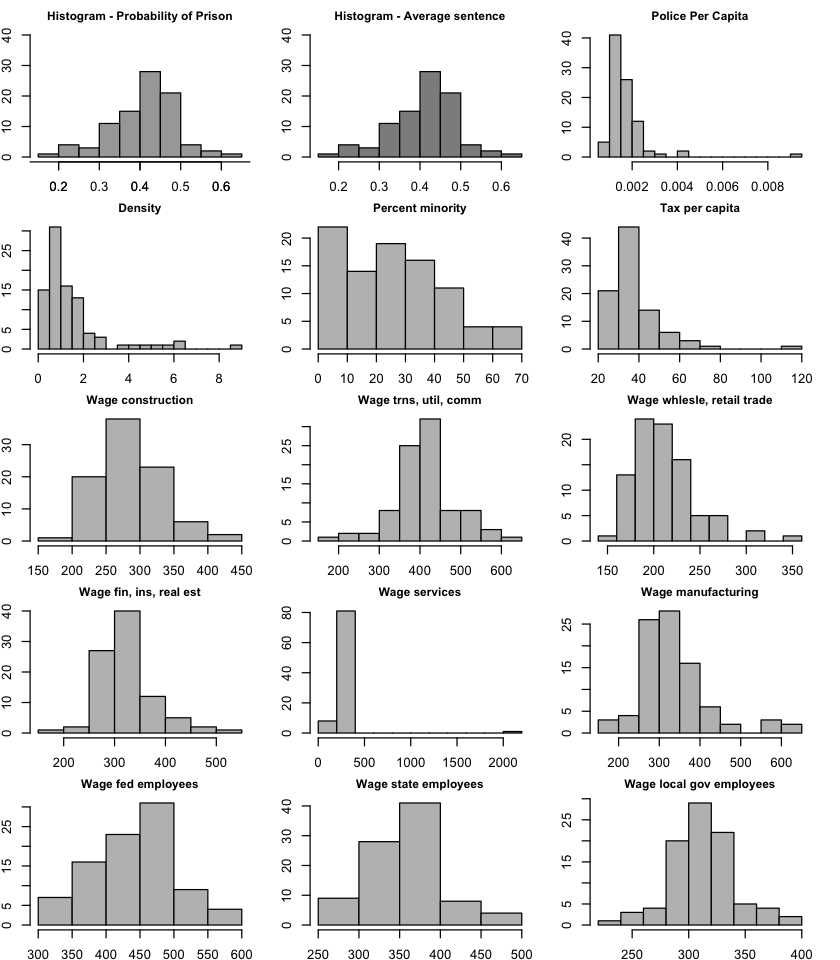

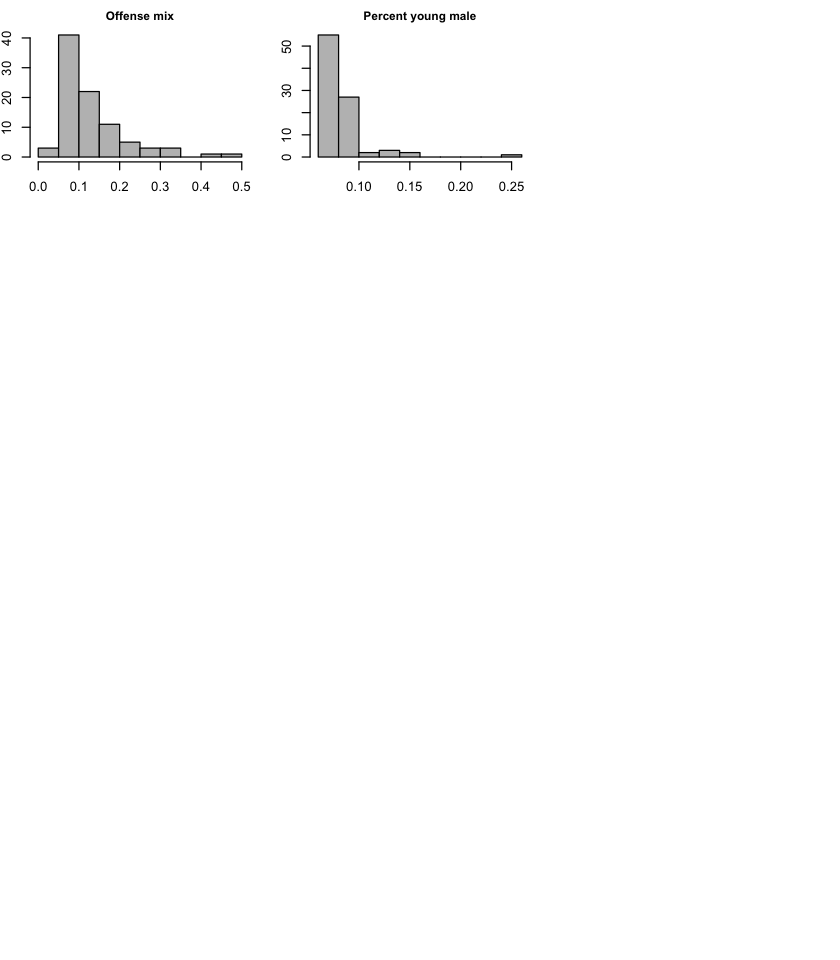

In [200]:
options(repr.plot.width=7, repr.plot.height=8)
par(mfrow = c(5, 3), mar = c(1,1,1,1)+0.9, cex.main = 0.9)
hist(clean$prbpris, main = "Histogram - Probability of Prison", xlab = "Probality of prison", 
     labels = F, ylim = c(0, 40), col = rgb(0.5, 0.5, 0.5, 0.7))
axis(side = 1, at = seq(0, 1, 0.2))
hist(clean$prbpris, main = "Histogram - Average sentence", xlab = "Average sentence, days", 
     labels = F, ylim = c(0, 40), col = rgb(0.5, 0.5, 0.5, 0.9))
hist(clean$polpc, breaks="FD", col="grey", main = "Police Per Capita")
hist(clean$density, breaks="FD", col="grey", main = "Density")
hist(clean$pctmin80, col="grey", main = "Percent minority")
hist(clean$taxpc, col="grey", main = "Tax per capita")
hist(clean$wcon, col="grey", main = "Wage construction")
hist(clean$wtuc, col="grey", main = "Wage trns, util, comm")
hist(clean$wtrd, col="grey", main = "Wage whlesle, retail trade")
hist(clean$wfir, col="grey", main = "Wage fin, ins, real est")
hist(clean$wser, col="grey", main = "Wage services")
hist(clean$wmfg, col="grey", main = "Wage manufacturing")
hist(clean$wfed, col="grey", main = "Wage fed employees")
hist(clean$wsta, col="grey", main = "Wage state employees")
hist(clean$wloc, col="grey", main = "Wage local gov employees")
hist(clean$mix, col="grey", main = "Offense mix")
hist(clean$pctymle, col="grey", main = "Percent young male")

### Bivariate analysis

Once we have finished exploring the quality of the variables in the dataset, and the main features of the variables that are of interest to the campaign that need to be taken into account for building the model that will help us answering the campaign's research question, we need to start exploring how the variables of interest relate to each other, mainly, how our variables of interest relate to `crime rate` and to other predictors of `crime rate` that may improve the model by reducing bias and increasing the efficiency of their estimated coeffcients.

#### Variables of interest

An initial exploration of the relationship between `crime rate` and `log(crime rate)` and our variables of interest (probability of arrest, probability of conviction, probability of prison and average sentence) indicates a relationship that is similar for both crime rate and its logarithmic form. Specifically, there seems to be a negative relationship with probability of arrest and probability of conviction but not a clear relationship with probability of prison or average sentence). Furthermore, there doesn't seem to be a strong indication of multicollinearity between the regressors, except for probability of arrest and average sentence.

Following this initial exploration, we will proceed to further investigate the relationships hinted at by the scatterplot matrix, using correlation analysis to quantify their strength.

In [201]:
vars.interest <- c("crmrte", "log.crmrte", "prbarr", "log.prbarr",
                   "prbconv", "log.prbconv", "prbpris", "log.prbpris")

# Log transformations
clean$log.crmrte <- log(clean$crmrte)
clean$log.taxpc <- log(clean$taxpc)
clean$log.prbarr <- log(clean$prbarr)
clean$log.prbconv <- log(clean$prbconv)
clean$log.prbpris <- log(clean$prbpris)
clean$log.polpc <- log(clean$polpc)

[1] "Scatterplot matrix of variables of interest and Crime rate"

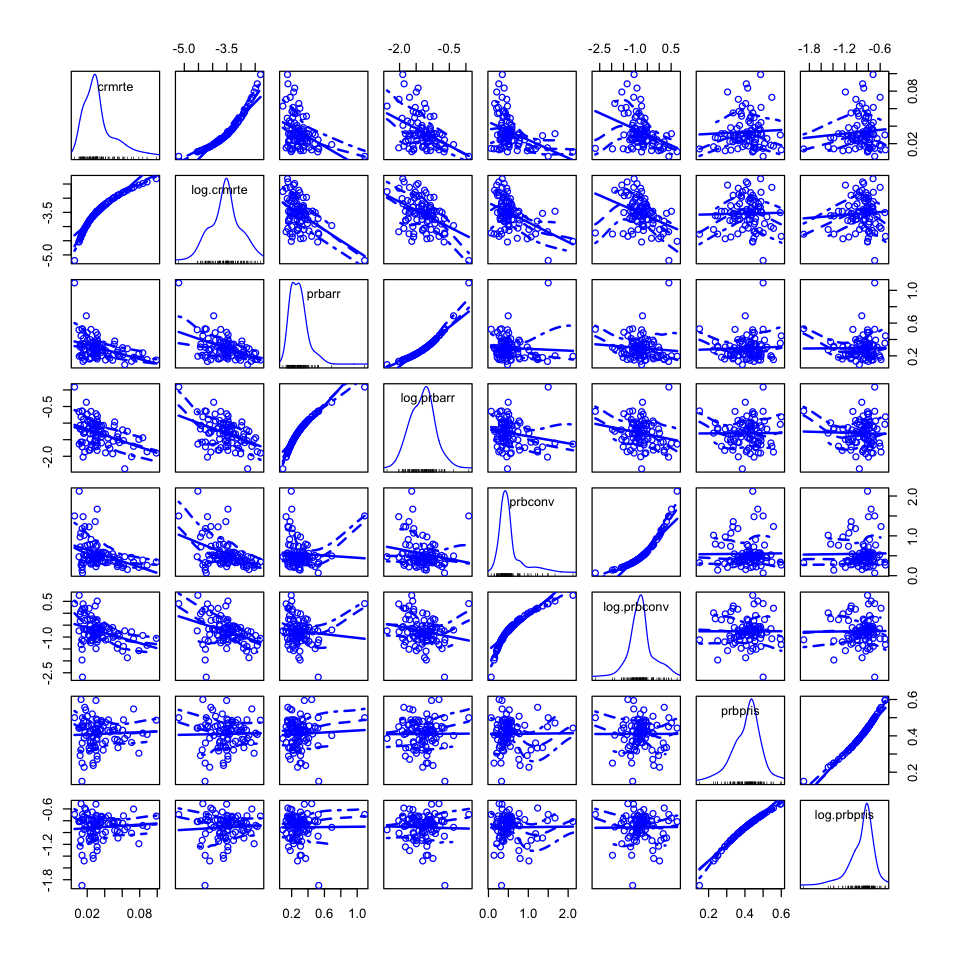

In [202]:
paste("Scatterplot matrix of variables of interest and Crime rate")
options(repr.plot.width=8, repr.plot.height=8)
scatterplotMatrix(clean[, vars.interest])

A correlation analysis shows that indeed probability of arrest and probability of conviction (both in their original and log-transformed forms) are negatively correlated with both crime rate and its logarithmic transformation, and also confirms that there is no correlation between these two variables and probability of prison and average sentence.

For all variables of interest (probability of arrest, probability of conviction and probability of arrest) the linear relationship measured by the correlation coefficient is higher when `crime rate` is log-transformed. Therefore, we should test both forms of this variable when building our model taking this into account (but also how the two forms of this variable affect the interpretability of results and how they affect the model assumptions).

The log form of our variables of interest does not change the correlation between them and `crime rate` heavily. However, it is still important to consider this transformation when defining our population model because they could improve the model's interpretability and assumptions.

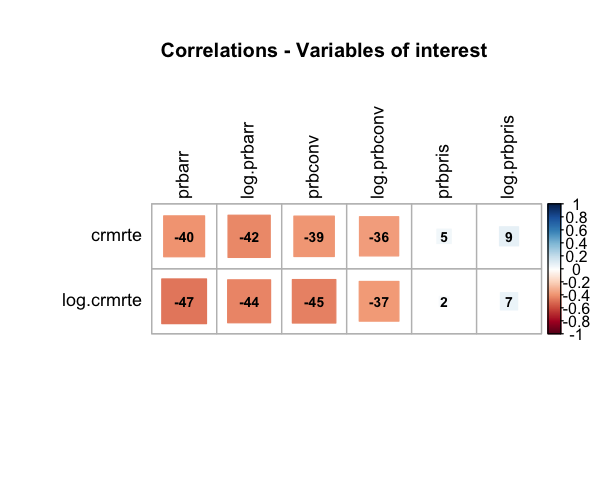

In [203]:
# Compute correlations
crime.corrs <- cor(select(clean, vars.interest))[1:2, 3:8]
# crime.corrs <- cor(select(clean, vars.interest))

# Plot correlations
options(repr.plot.width=5, repr.plot.height=4)
corrplot(crime.corrs, method = 'square',  order = 'original', diag = T, addCoef.col = T,
         tl.col = 'black', tl.cex = 0.9, addCoefasPercent = T, number.cex = 0.7)
title("Correlations - Variables of interest", cex.main = 1)

#### Control variables

Regarding possible control values, our main interest is to find variables that either confound the effect of our variables of interest on `crime rate` or that can increase the model's fit, reducing the variance of the model's error and of the coefficients of interest. 

To find which variables can be used as controls in our model, we did an initial exploratory analysis using a scatterplot matrix to find which of the candidate variables seemed to be related with `crime rate` or its logarithmic transformation. Upon inspecting the scatterplot matrix, we found that log of police per capita, tax per capita and density seem to have a relationship with `crime rate` and its logarithmic transformations. We will proceed to validate this using correlation analysis.

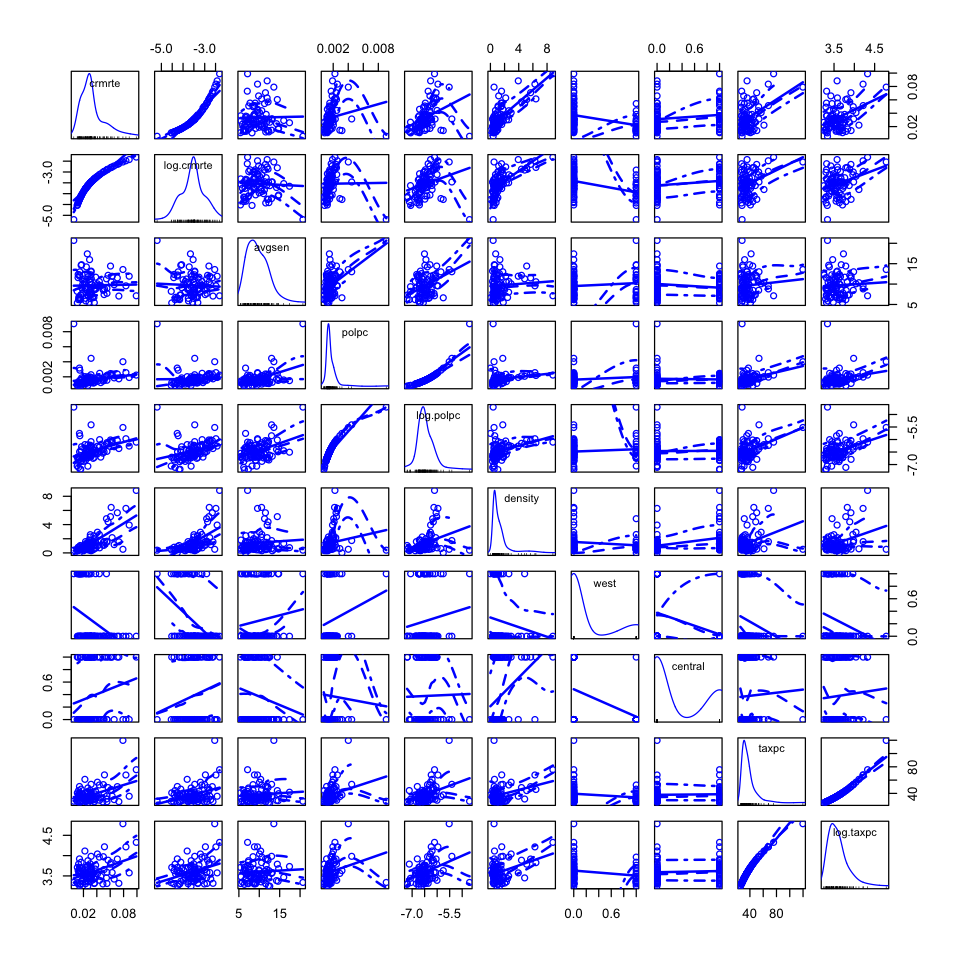

In [204]:
# Possible control variables
vars.control <- c('avgsen', 'polpc', 'log.polpc', 'density', 'west', 'central', 'taxpc', 'log.taxpc')

# Scatterplot matrix
options(repr.plot.width=8, repr.plot.height=8)
scatterplotMatrix(clean[, c('crmrte', 'log.crmrte', vars.control)])

The correlation matrix included below shows that `log.polpc`, `density`, `west` and `taxpc` are correlated with both `crime rate` and its logarithmic transformation and thus should be included in our estimated model, in order to immprove its predictive power and reduce the variance of the estimated coefficients of our variables of interest. Furthermore, density is both correlated with `crime rate` and `log.prbarr`, which indicates that it may be a possible confounding variable and should also be included in our estimated model to reduce the bias of the estimator of the coefficient of `log.prbarr`.

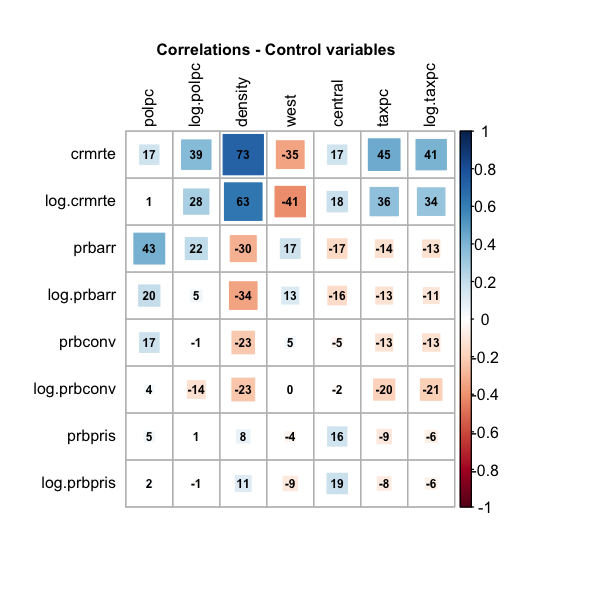

In [205]:
corrs.control <- cor(clean[, c(vars.interest, vars.control)], use = 'complete.obs')[1:8, 10:16]

options(repr.plot.width=5, repr.plot.height=5)
par(oma = c(0,0,0,4))
corrplot(corrs.control, method = 'square',  order = 'original', diag = T, addCoef.col = T,
         tl.col = 'black', tl.cex = 0.8, addCoefasPercent = T, number.cex = 0.6)
title("Correlations - Control variables", cex.main = 0.8)

In conclusion, the main recommendations provided by the exploratory data analysis, that need to be taken into account when specifying our regression model are the following:

- Both `crime rate` and its logarithmic transformation should be tested as possible dependent variables.


- `probability of arrest` and `probability of conviction`, two of our variables of interest, are correlated with both our candidate dependent variables and should be included in the regression model. Furthermore, their logarithmic transformation form is also correlated with the dependent variable and should be tested against their original form, using the resulting model's fit and meeting of the CLM asssumptions to decide which should be included in the specification of model 2.


- `probability of prison` does not seem to have an important relationship with `crime rate`. However, this is a result that is relevant to the campaign's research question; thus, it should be included in the regression, in order to show this variable's statistical and practical significance and the implications of this result to the political campaign.


- `log.polpc`, `density`, `west` and `taxpc` seem to have the strongest relationship with `crime rate` and its logarithmic form and we should consider including them within our model specification as controls. It is especially important to include `density`, since it is likely controlling for confounding effects.

## (3 and 4) Model Building and Regression Analysis

### Model 1: Our Base Model Measures the Elasticity of $crmrte$ with Respect to $prbarr$, $prbconv$, and $prbpris$

We wanted to understand if an increasing probability of incarceration for offenders ($prbpris$) is associated with lower crime rates ($crmrte$); consequently, our base model regresses our primary outcome variable $crmrte$ on the independent variable $prbpris$. However, an offender must first be arrested and convicted of a crime before s/he faces the possibility of serving prison time. Importantly, the probability that s/he will be arrested ($prbarr$) and the probability s/he will actually be convicted of a crime ($prbconv$) might also be associated with changes in $crmrte$. For example, we speculate that potential offenders could in principle be loathe to commit crimes in locales that have a higher propensity for arresting suspects. Similarly, convictions that do not result in incarceration but that place offenders on probation or that punish them with fines and/or community service could in principle reduce crime rate. Consequently, we also included $prbarr$ and $prbconv$ as regressors in our base model to control for these (and other) potential effects that could be associated with changes in these variables.

We wanted to understand if an increasing probability of incarceration for offenders ($prbpris$) is associated with lower crime rates ($crmrte$); consequently, our base model regresses our primary outcome variable $crmrte$ on the independent variable $prbpris$. However, an offender must first be arrested and convicted of a crime before s/he faces the possibility of serving prison time. Importantly, the probability that s/he will be arrested ($prbarr$) and the probability s/he will actually be convicted of a crime ($prbconv$) might also be associated with changes in $crmrte$. For example, we speculate that potential offenders could in principle be loathe to commit crimes in locales that have a higher propensity for arresting suspects. Similarly, convictions that do not result in incarceration but that place offenders on probation or that punish them with fines and/or community service could in principle reduce crime rate. Consequently, we also included $prbarr$ and $prbconv$ as regressors in our base model to control for these (and other) potential effects that could be associated with changes in these variables.

To begin, we individually regressed $crmrte$ on $prbarr$, $prbconv$, and $prbpris$. In so doing, we discovered that the $prbpris$ appears to be uncorrelated with $crmrte$ $(R^2 = 0.00)$; thus, to a first approximation and without accounting for other variables, this model suggests that an increasing probability of incarceration is not associated with lower crime rates nor is a decreasing probability of incarceration associated with higher crime rates. In contrast, increasing $prbarr$ and $prbconv$ appeared to be associated with lower $crmrte$. Specifically, each unit increase in $prbarr$ is associated with a 0.054 unit decrease in $crmrte$ $(R^2 = 0.16)$, while each unit increase in $prbconv$ is associated with a 0.021 unit decrease in $crmrte$ $(R^2 = 0.15)$. 

We also considered the possibility that the length of a possible prison sentence (i.e., $avgsen$) might confer a better fit than $prbpris$; however, we did not employ $avgsen$ as a regressor in our base model because (i) a simple regression of $crmrte$ on $avgsen$ reveals that $avgsen$ does not explain any variation in $crmrte$ (i.e., R$^2$=0) and (ii) it is also positively correlated with $prbpris$. Consequently, we judged that including $avgsen$ in our base model would only serve to increase the variance of our estimates for other coefficients with little gain. 

Next, we explored transformations that might improve our model's fit to these data. Although the maximum value of $crmrte$ is only ~18 times greater than its minimum value, (0.0055 vs. 0.099), we discovered that regressions of  $\log{crmrte}$ on $prbarr$ or $prbconv$ individually had better fits $(prbarr: R^2 = 0.22$ and $prbconv: R^2 = 0.20)$ than regressions of $crmrte$ on $prbarr$ or $prbconv$ $(prbarr: R^2 = 0.15$ and $prbconv: R^2 = 0.16)$. Thus, we chose to employ $\log_{crmrte}$ in our base model. 

We also chose to log-transform all of our regressors. Doing so sacrifices a slightly better fit as compared to modeling untransformed regressors $(R^2 = 0.45$ vs. $R^2 = 0.41)$. However, the units of our dependent variable and independent variables are somewhat disparate and obscure, and the log-transformed regressors facilitate more easily understood comparisons between them in terms of % changes. Specifically, each slope coefficient $\beta_j$ will describe how a 1% change in the corresponding regressor changes $crmrte$ by $\beta_j * 1\% = \beta_j\%$ Additionally, employing log-transformed regressors flattened the model's residuals vs. fitted values plot, which helped it conform to the zero-conditional mean assumption of the classic linear model (CLM). Employing log-transformed regressors also reduced the influence that all outliers have on our model (all data points have a Cook's distance below 0.5 in our model). Having fully specified our base model, we calculated the least-squares fit below. 

$$ \log crmrte = -4.71 - 0.72*\log prbarr - 0.47*\log prbconv + 0.15*\log prbpris $$

#### Relevance of Our Base Model

We set out to determine if the probability with which an offender receives a prison sentence is associated with a lower crime rate; the coefficients in our multivariate model indicate that the probability with which offenders receive prison sentences upon conviction is associated with an increasing crime rate, but that increasing probabilities of arrest and conviction are associated with decreasing crime rate. Specifically, we expect 1% increases in the probability of arrest or probability of conviction will correspond with 0.72% or 0.47% reductions in crime rate, respectively; in contrast, we our model predicts that a 1% increase in the probability of prison sentence is associated with a 0.15% increase in crime rate.

We speculate that $\beta_{\log{prbarr}}$ and $\beta_{\log{prbconv}}$ are practically significant, but that $\beta_{\log{prbpris}}$ probably is not. As we describe above, prison is very expensive relative to alternative sentences. However, our model suggests that compartively larger reductions in crime are associated with simply arresting suspects and convicting offenders. Incarceration, which is more costly, is not associated with higher or lower crime rates in a bivariate regression with $crmrte$, and it only shows a modest positive association (addressed below) in our multivariate model.

Importantly, we cannot claim that any causal effects exist in these relationships. For example, an increased probability of prison might be associated with higher crime rate because locales with higher violent crime rates sentence more people to prison; this in and of itself would not suggest that increasing the rates of incarceration would reduce crime rates. Similarly, areas with lower crime rates might simply have higher rates of arrests and convictions because the lower crime rates facilitate these effects; stated another way, other factors (e.g., poverty rates, education) could play a more direct role in reducing crime. 

#### Different Regressions We Employed To Build Our Base Model

In [206]:
# Here we test simple, untransformed linear regressions
model10 <- lm(crmrte ~ prbarr, data=clean)
model11 <- lm(crmrte ~ prbconv, data=clean)
model12 <- lm(crmrte ~ prbpris, data=clean)
model13 <- lm(crmrte ~ avgsen, data=clean)

# Here, we regress log(crmrte) on our key variables of interest: prbarr, prbconv, and prbpris.
model14 <- lm(log(crmrte) ~ prbarr, data=clean)
model15 <- lm(log(crmrte) ~ prbconv, data=clean)
model16 <- lm(log(crmrte) ~ prbpris, data=clean)

# Here, we regress log(crmrte) on our log transformations of our key variables of interest: prbarr, prbconv, and prbpris.
model17 <- lm(crmrte ~ log(prbarr), data=clean)
model18 <- lm(crmrte ~ log(prbconv), data=clean)
model19 <- lm(crmrte ~ log(prbpris), data=clean)

# This builds our base model
final_model1 <- lm(log(crmrte) ~ log(prbarr) + log(prbconv) + log(prbpris), data=clean)

# Displays the regressions we used to build the base model (as well as the base model)
stargazer(model10, model11, model12, model13, model14, model15, model16,
          model17, model18, model19, final_model1, type="html",
         report="vc", title="Building Our Base Model",
         keep.stat=c("rsq", "n"),
         omit.table.layout="n")


<table style="text-align:center"><caption><strong>Building Our Base Model</strong></caption>
<tr><td colspan="12" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="11"><em>Dependent variable:</em></td></tr>
<tr><td></td><td colspan="11" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td colspan="4">crmrte</td><td colspan="3">log(crmrte)</td><td colspan="3">crmrte</td><td>log(crmrte)</td></tr>
<tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td><td>(7)</td><td>(8)</td><td>(9)</td><td>(10)</td><td>(11)</td></tr>
<tr><td colspan="12" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">prbarr</td><td>-0.054</td><td></td><td></td><td></td><td>-1.884</td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></t

### Summary of Regressions Used to Build Our Base Model

_Our base model appears on the far right of the table [denoted as (10)]._

<table style="text-align:center"><caption><strong>Building Our Base Model</strong></caption>
<tr><td colspan="12" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="11"><em>Dependent variable:</em></td></tr>
<tr><td></td><td colspan="11" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td colspan="4">crmrte</td><td colspan="3">log(crmrte)</td><td colspan="3">crmrte</td><td>log(crmrte)</td></tr>
<tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td><td>(7)</td><td>(8)</td><td>(9)</td><td>(10)</td><td>(11)</td></tr>
<tr><td colspan="12" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">prbarr</td><td>-0.054</td><td></td><td></td><td></td><td>-1.884</td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">prbconv</td><td></td><td>-0.021</td><td></td><td></td><td></td><td>-0.692</td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">prbpris</td><td></td><td></td><td>0.011</td><td></td><td></td><td></td><td>0.146</td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">avgsen</td><td></td><td></td><td></td><td>0.0001</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(prbarr)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td>-0.020</td><td></td><td></td><td>-0.724</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(prbconv)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td>-0.012</td><td></td><td>-0.472</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(prbpris)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td>0.007</td><td>0.148</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">Constant</td><td>0.050</td><td>0.045</td><td>0.029</td><td>0.032</td><td>-2.985</td><td>-3.160</td><td>-3.602</td><td>0.008</td><td>0.024</td><td>0.040</td><td>-4.708</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td colspan="12" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Observations</td><td>90</td><td>90</td><td>90</td><td>90</td><td>90</td><td>90</td><td>90</td><td>90</td><td>90</td><td>90</td><td>90</td></tr>
<tr><td style="text-align:left">R<sup>2</sup></td><td>0.156</td><td>0.149</td><td>0.002</td><td>0.0004</td><td>0.224</td><td>0.200</td><td>0.0005</td><td>0.177</td><td>0.132</td><td>0.007</td><td>0.415</td></tr>
<tr><td colspan="12" style="border-bottom: 1px solid black"></td></tr></table>

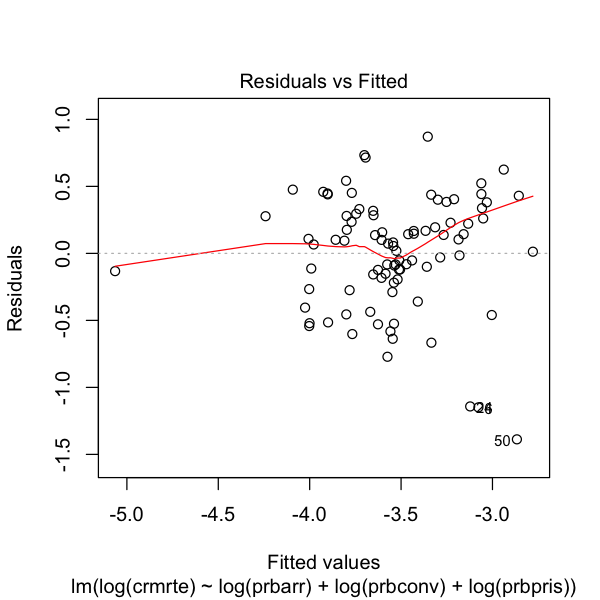

ERROR: Error in plot.xy(xy, type, ...): invalid graphics state


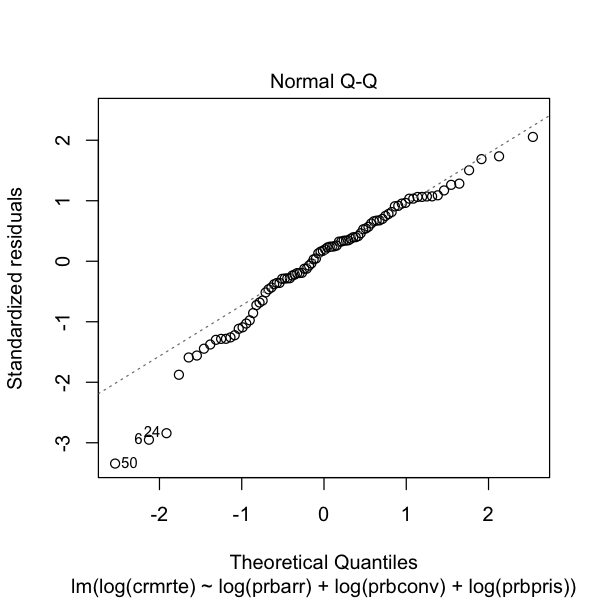

In [207]:
plot(final_model1)

In [ ]:
# Here, we evaluate simple scatter plots of our variables of interest
plot(clean$prbarr, clean$crmrte)
plot(clean$prbconv, clean$crmrte)
plot(clean$prbpris, clean$crmrte)

plot(clean$prbarr, log(clean$crmrte))
plot(clean$prbconv, log(clean$crmrte))
plot(clean$prbpris, log(clean$crmrte))

### Model 2: Adding $density$ and $polpc$ as Controls and to Improve Our Base Model's Fit

Having established our base model, we sought to introduce covariates that might (i) control for confounding effects and (ii) improve the model's fit to the underlying data without reducing its parsimony. In this vein, we chose to investigate the how incorporating $density$ and $polpc$ would affect our model. Population densities in North Carolina vary across almost six orders of magnitude, and counties with different population densities likely face different challenges with respect to crime, which is reflected in its positive correlation with $\log{crmrte}$. Moreover, $density$ is negatively correlated with both $\log{prbarr}$ and $\log{prbconv}$, but positively correlated with $\log{prbpris}$; thus, omitting this variable could introduce unaccounted bias in our base model. Given that we observed $\log{prbarr}$ is correlated with $\log{crmrte}$, we naturally wondered if having a higher concentration of police officers is also correlated with a lower $crmrte$. Curiously, $polpc$ is not strongly correlated with $\log{prbarr}$, $\log{prbpris}$, or $density$, but it is correlated with $\log{prbconv}$. Thus, we also added $polpc$ to our model to control for confounding effects on $\log{prbconv}$.

Next, we explored transformations that might improve our model's fit to these data. To start, we plotted $\log{crmrte}$ (i.e., the dependent variable in our base model) against $density$. We regressed $log{crmrte}$ on $density$ and obtained a relationship that explained the model well ($R^2 = 0.40$). We observed that the plot of $\log{crmrte}$ against density appears to follow a linear trend when $density < 2$, but that when $density \geq 2$, the trend has a smaller slope. We added a quadratic term ($density^2$) to account for the diminishing slope; doing so yielded a better fit than regressing $log{crmrte}$ on $density$ alone ($R^2 = 0.4553$). Additionally, the Akaike Information Criterion (AIC) also dropped from 106 to 100 when we added the quadratic term; this indicates that the model with the quadratic term is also more parsimonious. Consequently, we chose to regress on both $density$ and $density^2$ in our second model.

We also explored transformations that improved the linearity of regressing $\log{crmrte}$ against $polpc$ ($R^2=0$). Plotting $\log{crmrte}$ against $polpc$ gives a linear plot for most points expect for an extreme outlier, county #51. This point is highly leveraged and highly influences a regression of $\log{crmrte}$ against $polpc$ (Cook's distance > 1). Nevertheless, based on our EDA above, we could not justify excluding this data point from our analysis. We log-transformed $polpc$ to ameliorate the data point's influence. This appeared to be at least partially successful, as regressing $\log{crmrte}$ on $\log{polpc}$ produced a model with a better fit ($R^2 = 0.08$) and lower AIC (AIC=145 vs. AIC=152 for the untranformed variable). Consequently, we chose to regress on $\log{polpc}$ in our second model.

Having fully specified our second model, we calculated the least-squares fit below.

$$ \log crmrte = -4.71 - 0.72*\log prbarr - 0.47*\log prbconv + 0.15*\log prbpris + 0.31*density - 0.024*density^2 + 0.18*\log(polpc)$$

#### Relevance of Model 2 and How Key Variables Change

Including $density^2$, $density$, and $\log{polpc}$ as regressors drove the effects of each of our key variables closer to zero. The absolute values of the coefficients associated with $\log{prbarr}$ and $\log{prbconv}$ are reduced by 34% and 32%, respectively, relative to their values in our base model; this suggests that they are somewhat biased in model 1 by the exclusion of at least one of the coregressors we included in model 2. Notably, the coefficient for $\log{prbpris}$ dropped to almost zero (a 71% reduction from its value in model 1). 

Our second model also indicates that $\log{crmrte}$ rises in association with $density$ up until $density \approx 6.5$. This model fits our data well, given that only two points have $density > 6$. Additionally, our results indicate that a 1% increase in $polpc$ is associated with a 0.17% increase in $crmrte$.

We still cannot claim any causal effects exist in these relationships. Notwithstanding the effect that the outlier in $polpc$ exhibits on our regression, increasing $polpc$ could be correlated with a higher $crmrte$ because locales with higher crime rates have added to their police forces in an attempt to reduce crime. Conversely, lower values of $polpc$ could be correlated with lower $crmrte$ because other factors (e.g., income education) serve to keep crime rates low. 

We speculate that these results indicate $\beta_{\log{prbarr}}$ and $\beta_{\log{prbconv}}$ are still probably of practical significance, since modest percentage increases in either variable are still associated with relatively substantial percentage reductions in crime rate. Conversely, $\beta_{\log{prbpris}}$ is of even less practical value than we argued above, since the magnitude of its effect even is smaller in this model. $\beta_{density}$ and $\beta_{density^2}$ in total tell us that increasing $density$ is associated with higher $crmrte$, but only to a point. Finally, $\beta_{polpc}$ is perhaps of less practical significance, since it indicates that holding everything else constant, even a 10% increase in police per capita is associated with only a 1.7% increase in crime rate.

#### Different Regressions We Employed To Build Model 2

In [ ]:
# Here, we test regressions of log(crmrte) on density and polpc
model20 <- lm(log(crmrte) ~ density, data=clean)
paste("Model:", summary(model20)$call[2])
paste("Akaike Information Criterion:", round(AIC(model20), 0))
paste("*******************************")
model21 <- lm(log(crmrte) ~ polpc, data=clean)
paste("Model:", summary(model21)$call[2])
paste("Akaike Information Criterion:", round(AIC(model21), 0))
paste("*******************************")

# Here, we test regressions of log(crmrte) on log transformations of density and polpc
model22 <- lm(log(crmrte) ~ log(density), data=clean)
model23 <- lm(log(crmrte) ~ log(polpc), data=clean)
paste("Model:", summary(model23)$call[2])
paste("Akaike Information Criterion:", round(AIC(model23), 0))
paste("*******************************")

# Here, we test regressions of log(crmrte) on density + density^2
model24 <- lm(log(crmrte) ~ density + I(density^2), data=clean)
paste("Model:", summary(model24)$call[2])
paste("Akaike Information Criterion:", round(AIC(model24), 0))
paste("*******************************")

# This builds model 2
final_model2 <- lm(log(crmrte) ~ log(prbarr) + log(prbconv) + log(prbpris)
             + density + I(density^2) + log(polpc), data=clean)

### CLM Assumptions for Model 2



In [ ]:
# Displays the regressions we used to build the base model (as well as the base model)
stargazer(model20, model21, model22, model23, model24, final_model2, 
          type="html", report="vc", title="Building Our Base Model",
          keep.stat=c("rsq", "n"), omit.table.layout="n")

### Summary of Regressions Used to Build Model #2

_Model #2 appears on the far right of the table [denoted as (6)]._


<table style="text-align:center"><caption><strong>Building Our Base Model</strong></caption>
<tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable:</em></td></tr>
<tr><td></td><td colspan="6" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td colspan="6">log(crmrte)</td></tr>
<tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td></tr>
<tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">log(prbarr)</td><td></td><td></td><td></td><td></td><td></td><td>-0.475</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(prbconv)</td><td></td><td></td><td></td><td></td><td></td><td>-0.321</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(prbpris)</td><td></td><td></td><td></td><td></td><td></td><td>0.043</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">density</td><td>0.228</td><td></td><td></td><td></td><td>0.469</td><td>0.305</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">polpc</td><td></td><td>5.762</td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(density)</td><td></td><td></td><td>0.197</td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(polpc)</td><td></td><td></td><td></td><td>0.417</td><td></td><td>0.176</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">I(density2)</td><td></td><td></td><td></td><td></td><td>-0.035</td><td>-0.024</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">Constant</td><td>-3.869</td><td>-3.552</td><td>-3.525</td><td>-0.847</td><td>-4.063</td><td>-3.563</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td></td></tr>
<tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Observations</td><td>90</td><td>90</td><td>90</td><td>90</td><td>90</td><td>90</td></tr>
<tr><td style="text-align:left">R<sup>2</sup></td><td>0.401</td><td>0.0001</td><td>0.244</td><td>0.081</td><td>0.455</td><td>0.597</td></tr>
<tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr></table>

In [ ]:
# Here, we evaluate simple scatter plots of our variables of interest

# Outputs scatter plots of log(crmrte) against polpc and log(polpc)
plot(clean$polpc, log(clean$crmrte))
plot(log(clean$polpc), log(clean$crmrte))

# Maps a quadratic function we use to fit density to log(crmrte)
first <- clean$density
second <- (clean$density)^2

model <- lm(log(clean$crmrte) ~ first + second)
summary(model)
paste("Akaike Information Criterion:", round(AIC(model), 0))
paste("Adjusted R-squared:", round(summary(model)$adj.r.squared, 2))

densityvalues <- seq(0, 10, 0.1)
predictedvalues <- predict(model, list(first=densityvalues, second=densityvalues^2))
plot(clean$density, log(clean$crmrte))
lines(densityvalues, predictedvalues, col="darkgreen", lwd=3)

### Model 3: Two of Our Key Variable Coefficients ($\beta_{\log{prbarr}}$ and $\beta_{\log{prbconv}}$) Exhibit Robustness to Model Specification, but $\beta_{\log{prbpris}}$ Does Not

Finally, we tested the robustness of our base model coefficients to pertubations in model specification. To do so, we added untransformed regressors that correspond to every variable remaining in the dataset that we did not specifically address in model 2, with the exception of $year$ and $county$. (For the sake of being concise, we do not provide the full specification within the text below, but we refer the reader to the table below that contains coefficients for all three models.) 

Of the key variables we considered, $\log{prbpris}$ appears to be sensitive to model specification, whereas $\log{prbarr}$ and $\log{prbconv}$ appear to be relatively robust. Compared to the value we calculated in model 1, $\beta_{\log{prbpris}}$ goes from being positive to being negative; it is also relatively close to zero. We interpret these results to mean that $\log{prbpris}$ is not a meaningful predictor of $crmrte$. In contrast, $\beta_{\log{prbarr}}$ and $\beta_{\log{prbconv}}$ are relatively unaltered from our original model specification; in fact, their absolute values are only reduced by 31% and 41%, respectively. This is roughly the same magnitude change for each coefficient that we observed in model 2; furthermore, we previously judged that at these levels, these coefficients were of practical significance. In total, we interpret these results to mean that $\beta_{\log{prbarr}}$ and $\beta_{\log{prbconv}}$ are robust to model specification.

With respect to our motivating question (i.e., Is crime rate associated with incarceration rate?), these results reinforce the conclusions we have already drawn about our three key variables. Namely, that comparatively larger reductions in crime are associated with simply arresting suspects and convicting offenders; incarceration, which is more costly, is not associated with higher or lower crime rates.

#### Code to Calculate Model 3

In [ ]:
final_model3 <- lm(log(crmrte) ~ log(prbarr) + log(prbconv) + log(prbpris)
             + density + I(density^2) + log(polpc) + taxpc + west 
             + central + urban + pctmin80 + wcon + wtuc + wfir + wser
             + wmfg + wfed + wsta + wloc + mix + pctymle, data=clean)

### Summary of Coefficients for Models 1, 2, and 3

In [ ]:
stargazer(final_model1, test2, final_model3, type="text",
         report="vc", title="Linear Models Predicting Crime Rate",
         keep.stat=c("rsq", "n"),
         omit.table.layout="n")

<table style="text-align:center"><caption><strong>Linear Models Predicting Crime Rate</strong></caption>
<tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="3"><em>Dependent variable:</em></td></tr>
<tr><td></td><td colspan="3" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td colspan="3">log(crmrte)</td></tr>
<tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td></tr>
<tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">log(prbarr)</td><td>-0.724</td><td>-0.475</td><td>-0.500</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(prbconv)</td><td>-0.472</td><td>-0.321</td><td>-0.276</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(prbpris)</td><td>0.148</td><td>0.043</td><td>-0.024</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">density</td><td></td><td>0.305</td><td>0.373</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">I(density2)</td><td></td><td>-0.024</td><td>-0.031</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(polpc)</td><td></td><td>0.176</td><td>0.128</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">taxpc</td><td></td><td></td><td>0.008</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">west</td><td></td><td></td><td>-0.033</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">central</td><td></td><td></td><td>-0.072</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">urban</td><td></td><td></td><td>-0.264</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">pctmin80</td><td></td><td></td><td>0.013</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">wcon</td><td></td><td></td><td>0.001</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">wtuc</td><td></td><td></td><td>-0.0001</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">wfir</td><td></td><td></td><td>-0.001</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">wser</td><td></td><td></td><td>-0.0004</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">wmfg</td><td></td><td></td><td>-0.00002</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">wfed</td><td></td><td></td><td>0.002</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">wsta</td><td></td><td></td><td>-0.001</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">wloc</td><td></td><td></td><td>0.0003</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">mix</td><td></td><td></td><td>0.104</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">pctymle</td><td></td><td></td><td>1.945</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">Constant</td><td>-4.708</td><td>-3.563</td><td>-4.992</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Observations</td><td>90</td><td>90</td><td>90</td></tr>
<tr><td style="text-align:left">R<sup>2</sup></td><td>0.415</td><td>0.597</td><td>0.838</td></tr>
<tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr></table>

## (5) Omitted Variable Bias

There are many reasons why a person might commit a crime. It could be because that person cannot find a job but still needs to provide for his/her family, has a drug addiction or mental instability, or did not have a good role model growing up. Though it can be difficult to pinpoint the underlying motivation, there are several factors that are not included in the dataset that could influence the inclination of committing a crime and bias our results. 

We will discuss some of the omitted variables and how it might over or underestimate the relationships between probability of arrest and conviction with crime rate. To do this, we first write the equation for our base model with the omitted variable $omitvar$, as denoted below:

$$
crmrte = \beta_0 + \beta_1 prbarr + \beta_2 prbconv + \beta_3 prbpris + \beta_4 omitvar + u 
$$

We also write the individual regession equations for the omitted variable on each of the regressors of our base model $prbarr$, $prbconv$, and $prbpris$:

$$
omitvar = \gamma_{0 \ prbarr} + \gamma_{1 \ prbarr} \cdot prbarr + w_{prbarr} \\
omitvar = \gamma_{0 \ prbconv} + \gamma_{1 \ prbconv} \cdot prbconv + w_{prbconv} \\
omitvar = \gamma_{0 \ prbpris} + \gamma_{1 \ prbpris} \cdot prbpris + w_{prbpris} \\
$$

For each omitted variable, we identify the signs of $\beta_1$, $\beta_2$, $\beta_3$, $\beta_4$, and $\gamma_1$. The direction of bias is determined by multiplying the signs of $\beta_4$ and $\gamma_1$. The bias with respect to zero is determined by the signs of the respective slope coefficient $\beta_1$, $\beta_2$, or $\beta_3$ with the direction of bias. A bias towards zero indicates an underestimation of the associated slope coefficient $\beta_1$, $\beta_2$, or $\beta_3$, while a bias away from zero indicates an overestimation.

**Education**

We expect crime rate to be negatively correlated with education. As the population of the county becomes more educated, they are more likely to understand the consequences of their actions. In addition, they will have more opportunities to pursue, reducing their likelihood to commit a crime. As such, we also expect that the probability of arrests, conviction, and prison in these more educated counties to decrease.

| Regressor | $\beta_1$ | $\beta_2$ | $\beta_3$ | $\beta_4$ | $\gamma_1$ | Direction of bias | Bias wrt zero  |
| :-------: | :-------: |:---------:|:---------:|:---------:|:----------:| :----------------:|:--------------:|
|  prbarr   | negative  |   -       |    -      | negative  |  negative  |      positive     | towards zero   |
|  prbconv  |   -       | negative  |    -      | negative  |  negative  |      positive     | towards zero   |
|  prbpris  |   -       |   -       | positive  | negative  |  negative  |      positive     | away from zero |

**Unemployment**

We expect unemployment to be positively correlated with crime rate. As more people in a given population are unemployed, these people may be unable to support themselves and their families. With no income and more time on their hands, these people may be more likely to commit a crime. Based on this, we would expect the probability of arrest, conviction, and prison to also increase in areas with increased unemployment. 

| Regressor | $\beta_1$ | $\beta_2$ | $\beta_3$ | $\beta_4$ | $\gamma_1$ | Direction of bias | Bias wrt zero  |
| :-------: | :-------: |:---------:|:---------:|:---------:|:----------:| :----------------:|:--------------:|
|  prbarr   | negative  |   -       |    -      | positive  |  positive  |      positive     | towards zero   |
|  prbconv  |   -       | negative  |    -      | positive  |  positive  |      positive     | towards zero   |
|  prbpris  |   -       |   -       | positive  | positive  |  positive  |      positive     | away from zero |

**Racial diversity**

We expect that higher levels of racial diversity would result in a reduction in crime rate, probability of arrest, and probability of conviction. Racially diverse areas provide different perspectives to members of the community, improving understanding and empathy. With a more cohesive community, crimes committed among the population would decrease. In addition, the probability of arrest, conviction, and prison would also be reduced in these areas as local officers, jurors, and judge may be less discrimatory in their decisions. A proxy for racial diversity could be the percent minority measured in 1980 (pctmin80). A higher percent minority could indicate that there is higher racial diversity. 

| Regressor | $\beta_1$ | $\beta_2$ | $\beta_3$ | $\beta_4$ | $\gamma_1$ | Direction of bias | Bias wrt zero  |
| :-------: | :-------: |:---------:|:---------:|:---------:|:----------:| :----------------:|:--------------:|
|  prbarr   | negative  |   -       |    -      | negative  |  negative  |      positive     | towards zero   |
|  prbconv  |   -       | negative  |    -      | negative  |  negative  |      positive     | towards zero   |
|  prbpris  |   -       |   -       | positive  | negative  |  negative  |      positive     | away from zero |

**Youth programs**

We expect youth programs such as Big Brothers Big Sisters and Boys and Girls Club of America to reduce the likelihood of crime rate and the probability of arrests, conviction, and prison. Youths that may grow up in a troubled household or neighborhood may need a good role model which these programs help provide to reduce their inclination to commit crimes when they become adults. 

| Regressor | $\beta_1$ | $\beta_2$ | $\beta_3$ | $\beta_4$ | $\gamma_1$ | Direction of bias | Bias wrt zero  |
| :-------: | :-------: |:---------:|:---------:|:---------:|:----------:| :----------------:|:--------------:|
|  prbarr   | negative  |   -       |    -      | negative  |  negative  |      positive     | towards zero   |
|  prbconv  |   -       | negative  |    -      | negative  |  negative  |      positive     | towards zero   |
|  prbpris  |   -       |   -       | positive  | negative  |  negative  |      positive     | away from zero |

**Drug use**

We expect that areas with increased drug use would have an elevated crime rate. Greater drug use leads to increases in drug-related crimes, including theft. Drug use may influence members of a population to behave irrationally, increasing the likelihood of committing a crime, especially to support a drug addiction. We also expect that areas with increased drug use would have increased probability of arrest, conviction, and prison for that population as using drugs is grounds for arrest, while jurors and judges may have the perception that drug users are more unstable.

| Regressor | $\beta_1$ | $\beta_2$ | $\beta_3$ | $\beta_4$ | $\gamma_1$ | Direction of bias | Bias wrt zero  |
| :-------: | :-------: |:---------:|:---------:|:---------:|:----------:| :----------------:|:--------------:|
|  prbarr   | negative  |   -       |    -      | positive  |  positive  |      positive     | towards zero   |
|  prbconv  |   -       | negative  |    -      | positive  |  positive  |      positive     | towards zero   |
|  prbpris  |   -       |   -       | positive  | positive  |  positive  |      positive     | away from zero |

**Severity of crimes**

We expect that areas with higher crime severity would also have a higher crime rate. More serious crimes would require more law enforcement resources, leading to fewer resources to discourage minor crimes. This would result in increased levels of less serious crime. Areas with higher crime severity will also have higher probability of arrest and conviction for people who commit crimes. We expect that these areas are subject to more stringent policing and monitoring. A proxy for severity of crimes could be average sentence (avgsen), as counties with a ratio of more severe crimes would have a higher average sentence. However, avgsen may be limited as a proxy since the mean for the variable is quite low and may not be sufficient to capture severity of crimes.

| Regressor | $\beta_1$ | $\beta_2$ | $\beta_3$ | $\beta_4$ | $\gamma_1$ | Direction of bias | Bias wrt zero  |
| :-------: | :-------: |:---------:|:---------:|:---------:|:----------:| :----------------:|:--------------:|
|  prbarr   | negative  |   -       |    -      | positive  |  positive  |      positive     | towards zero   |
|  prbconv  |   -       | negative  |    -      | positive  |  positive  |      positive     | towards zero   |
|  prbpris  |   -       |   -       | positive  | positive  |  positive  |      positive     | away from zero |

All of the omitted variables that we have identified seem to influence potential bias in similar manner. The slope coefficients of the probability of arrest and convicitions on crime rate are underestimated, while the slope coefficient of the probability of prison on crime rate is overestimated. This supports our key findings that there is a real association of probability of arrest and conviction with crime rate, and our estimations for these are conservative. The overestimation of the slope coefficient for probability of prison also does not contradict our findings, as we show that the probability of prison is less associated with crime rate, and that small association that we have estimated may actually be even smaller.

## (6) Conclusions

Our analysis sought to address if the probability of incarceration or the probabilities of either step leading to incarceration (i.e., arrest and conviction) are associated in any discernable way with crime rate. We found that $prbpris$ does not correlate with $crmrte$ in any meaningful way; this suggests that within the current dataset, incarceration rates do not correlate with crime rate. Put another way, an increasing probability of incarceration is not associated with higher or lower crime rates. Conversely, we found that increasing rates of arrest and conviction (measured by $prbarr$ and $prbconv$, respectively) are associated with lower crime rates. In total, these observations suggest that your campaign should: (i) explore cheaper alternatives to imprisonment as criminal penalties and (ii) test implementing measures that could increase arrest and conviction rates. 

In light of the fact that we cannot define a causal relationship between these variables, we recommend that you establish pilot programs in some counties that attempt to test some of these observations. If retrospective analyses indicate that the programs appear to have reduced crime rates (especially in comparison with similar counties that are not executing a similar pilot), then you can launch these initiatives statewide. Specifically, we recommend that you campaign on pilot policy prescriptions that are designed to (i) increase arrest rates, (ii) increase conviction rates, and (iii) offer alternatives to prison for offenders. For example, you might consider increasing funding to process evidence (e.g., rape kits, DNA tests) to crack cold cases and increase arrests, adding more prosecutorial staff to process more cases, or altering sentencing guidelines to disfavor prison for offenders convicted of non-violent crimes.

## (7) References

1. https://www.naacp.org/criminal-justice-fact-sheet/
2. https://www.ncdps.gov/adult-corrections/cost-of-corrections

# Add this section

#### CLM Assumptions for Model 1

In order to infer appropriate conclusions from our model, we need to evaluate if the model meets the six classical linear model assumptions.

*1. Linear in parameters*: Although we have utilized log transformations in the variables, our population model is employed as

$$log(y) = \beta_0 + \beta_1 log(x_1) + \beta_2 log(x_2) + \beta_3 (x_3) + u$$

Because the parameters $\beta_0$ through $\beta_3$ are linear, our model meets the linear in parameters assumption.

*2. Random sampling*: With some research, we found that there are a total of 100 counties in North Carolina, however our data set only includes 90 observations. Because of the limited information on how the data was collected, we cannot conclude whether or not we have met the random sampling assumption. There could be a number of reasons why these counties were missing- it could be because the counties did not have the resources to collect this type of information or simply did not want to share them. In these scenarios, the data set would be missing full representation of the entire population of North Carolina counties.

*3. No perfect collinearity*: Because the model was able to successfully regress, we can confirm that our model does not have perfect collinearity. However, we still want to ensure that we don't have imperfect collinearity in our model. We calculated the variance inflation factor (VIF) for each explanatory variable. The VIF values were all much less than 10, indicating that our model does not have the collinearity that could increase the estimator's variance. 

In [208]:
paste("VIF for explanatory variables:")
vif(final_model1)

[1] "VIF for explanatory variables:"

log(prbarr) log(prbconv) log(prbpris) 
    1.043425     1.042722     1.000810

*4. Zero conditional mean*: To satisfy the zero conditional mean assumption, the error $u$ should have an expected value of zero given any values of the explanatory variables. To evaluate this, we used the residuals as an estimate of the error and looked at the residuals vs fitted values plot. The red spline estimates the mean of the residuals across the fitted values and a flat line at 0 would indicate a zero conditional mean. Using log transformations of the explanatory variables did help flatten the mean line compared with a model without these transformations. However, our plot for model 1 still shows some curvature towards the right side of the plot, as shown in graph (a) below. This indicates that there could be some biasness in our model.

[1] "Model 1 diagnostic plots:"

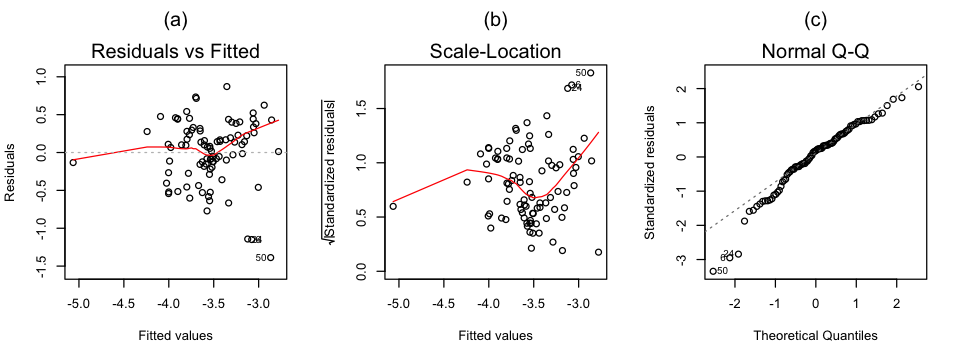

In [209]:
options(repr.plot.width=8, repr.plot.height=3)
paste("Model 1 diagnostic plots:")
par(mfrow=c(1,3))
plot(final_model1, which = 1)
mtext("(a)", side = 3, padj = -2.5)
plot(final_model1, which = 3)
mtext("(b)", side = 3, padj = -2.5)
plot(final_model1, which = 2)
mtext("(c)", side = 3, padj = -2.5)

Although our model may not be completely unbiased, we can still determine if our model has consistency by satisfying the weaker exogeneity assumption $E(u) = 0$ and $Cov(x_j, u)$. To approximate these, we calculated the expectation of the sample residuals and covariances of the residuals with each explanatory  variable and found that they were all nearly zero, or very close to zero. Thus, we are able to approximately satisfy the exogeneity assumption and conclude that our estimators are consistent considering we have already met the previous 3 CLM assumptions.

In [210]:
u_model1 = final_model1$residuals
paste("$E(u)$ =", mean(u_model1))
paste("$Cov(prbarr, u)$ = ", round(cov(clean$prbarr, u_model1), digits = 4))
paste("$Cov(prbconv, u)$ = ", round(cov(clean$prbconv, u_model1), digits = 4))
paste("$Cov(prbpris, u)$ = ", round(cov(clean$prbpris, u_model1), digits = 4))

[1] "$E(u)$ = -8.43298473104628e-18"

[1] "$Cov(prbarr, u)$ =  -0.0017"

[1] "$Cov(prbconv, u)$ =  -0.0205"

[1] "$Cov(prbpris, u)$ =  -0.0015"

*5. Homoskedasticity*: In graph (a), we see that the variances in the data increases with an increasing fitted value, as the band around the red spline grows bigger. This indicates that our model does have some degree of heterskedasticity. Graph (b) shown above supports this conclusion, as the red spline curve estimating the mean of the square root of the absolute value of the residuals is not a straight flat line. Because of this, and also because it is best practice, we will use the heterskedastic robust standard errors when determining statistical significance of the estimators.

*6. Normality of errors*: Graph (c) shown above shows that there the residuals is somewhat close to normal distribution, but ultimately deviates from normal distribution with a left skew as indicated by the data points veering away from the dotted line. However, looking at the histogram of the residuals show that there is not extreme skewness, and with a data set with 90 observations, we are able to use the central limit thereom to argue that the estimators satistify asympototic normality.

#### CLM Assumptions for Model 2

1. *Linear in parameters:* Our equation for model 2 meets the linearity in parameters assumption as the parameters $\beta_j$ are linear.
* *Random sampling:* We use the same dataset as in model 1, so our rationale that the data may or may not have random sampling is the same.
* *No perfect collinearity:* There is no perfect collinearity, however the variance inflation factors for $density$ and $density^2$ were calculated to be high. This does not alarm us as these represent a quadratic transformation and does not indicate collinearity with a different explanatory variable.
* *Zero conditional mean:* The red spline curve in the residuals vs fitted graph is fairly flat in the center, while curving downwards near the edges. Although the model may not necessarily meet zero conditional mean, we are still able to argue that it meets exogeneity based on the appoximations of $E(u)$ and $Cov(x_j, u)$. 
* *Homoskedasticity:* The red spline curve in the scale-location graph shows that there is a fair amount of heterskedasticity, however this pronouced curvature may be due to having less data points on the left side of the graph. Nevertheless, we continue to use heterskedastic robust standard errors.
* *Normality of errors:* The points on the normal q-q graph do deviate from a normal distribution towards the edges, but because there is no extreme skewness and a large number of observations, we are still able to rely on the central limit theorem.

**version2:**

1. *Linear in parameters:* Our equation for model 2 meets the linearity in parameters assumption as the parameters $\beta_j$ are linear.
* *Random sampling:* We use the same dataset as in model 1, so our rationale that the data may or may not have random sampling is the same.
* *No perfect collinearity:* There is no perfect collinearity, however the variance inflation factors for $density$ and $density^2$ were calculated to be high. This does not alarm us as these represent a quadratic transformation and does not indicate collinearity with a different explanatory variable.
* *Zero conditional mean:* The red spline curve in graph (d) is fairly flat in the center, while curving downwards near the edges. Although the model may not necessarily meet zero conditional mean, we are still able to argue that it meets exogeneity based on the appoximations of $E(u)$ and $Cov(x_j, u)$. 
* *Homoskedasticity:* The red spline curve in graph (e) shows that there is a fair amount of heterskedasticity, however this pronouced curvature may be due to having less data points on the left side of the graph. Nevertheless, we continue to use heterskedastic robust standard errors.
* *Normality of errors:* The points on graph (f) do deviate from a normal distribution towards the edges, but because there is no extreme skewness and a large number of observations, we are still able to rely on the central limit theorem.

[1] "Model 2 diagnostic plots:"

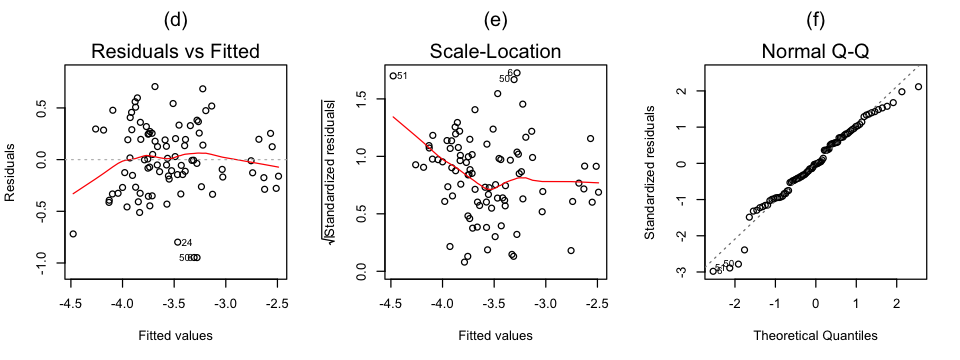

In [211]:
paste("Model 2 diagnostic plots:")
par(mfrow=c(1,3))
plot(final_model2, which = 1)
mtext("(d)", side = 3, padj = -2.5)
plot(final_model2, which = 3)
mtext("(e)", side = 3, padj = -2.5)
plot(final_model2, which = 2)
mtext("(f)", side = 3, padj = -2.5)

#### CLM Assumptions for Model 3

1. *Linear in parameters:* Our equation for model 2 meets the linearity in parameters assumption as the parameters $\beta_j$ are linear.
* *Random sampling:* We use the same dataset as in model 1, so our rationale that the data may or may not have random sampling is the same.
* *No perfect collinearity:* There is no perfect collinearity and the variance inflation factor for all explanatory variables is less than 10, besides $density$ and $density^2$ as discussed previously.
* *Zero conditional mean:* The red spline curves in the residuals vs fitted graph is quite flat and approximately meets the zero conditional mean assumption. Meeting this and the previous assumptions indicate that model 3 is unbiased.
* *Homoskedasticity:* The red spline curve in the scale-location graph is fairly flat, however not perfectly homoskedastic. We will again continue to use heterskedastic robust standard errors.
* *Normality of errors:* There is a small left skew shown in the normal q-q graph, however we are still able to use the central limit theorem as there is no extreme skewness.

**version2:**

1. *Linear in parameters:* Our equation for model 2 meets the linearity in parameters assumption as the parameters $\beta_j$ are linear.
* *Random sampling:* We use the same dataset as in model 1, so our rationale that the data may or may not have random sampling is the same.
* *No perfect collinearity:* There is no perfect collinearity and the variance inflation factor for all explanatory variables is less than 10, besides $density$ and $density^2$ as discussed previously.
* *Zero conditional mean:* The red spline curves in graph (g) is quite flat and approximately meets the zero conditional mean assumption. Meeting this and the previous assumptions indicate that model 3 is unbiased.
* *Homoskedasticity:* The red spline curve in graph (h) is fairly flat, however not perfectly homoskedastic. We will again continue to use heterskedastic robust standard errors.
* *Normality of errors:* There is a small left skew, as shown in graph (i), however we are still able to use the central limit theorem as there is no extreme skewness.

[1] "Model 3 diagnostic plots:"

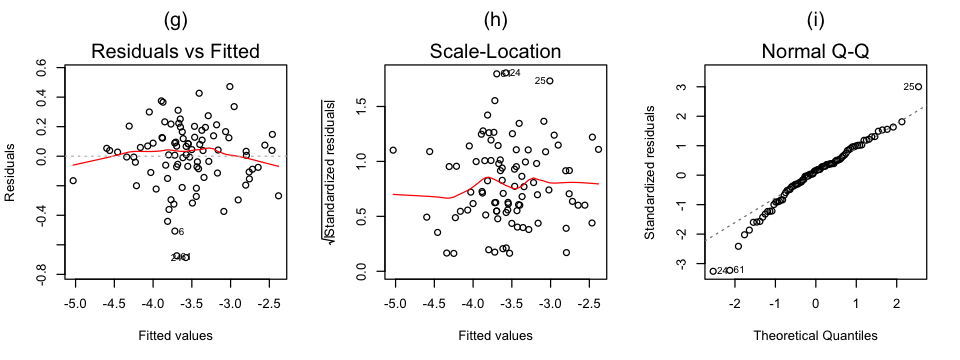

In [212]:
paste("Model 3 diagnostic plots:")
par(mfrow=c(1,3))
plot(final_model3, which = 1)
mtext("(g)", side = 3, padj = -2.5)
plot(final_model3, which = 3)
mtext("(h)", side = 3, padj = -2.5)
plot(final_model3, which = 2)
mtext("(i)", side = 3, padj = -2.5)

# Extra (Ignore this)

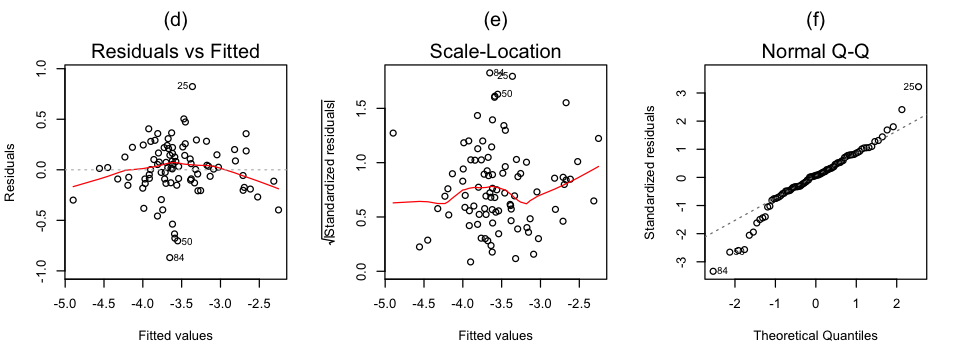

In [213]:
test2 <- lm(log(crmrte) ~ log(prbarr) + log(prbconv) + log(prbpris)
             + density + + I(density^2) + log(polpc) + avgsen + pctmin80, data=clean)
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow=c(1,3))
plot(test2, which = 1)
mtext("(d)", side = 3, padj = -2.5)
plot(test2, which = 3)
mtext("(e)", side = 3, padj = -2.5)
plot(test2, which = 2)
mtext("(f)", side = 3, padj = -2.5)

**Prior convictions**

We expect that areas with a high proportion of crimes committed by criminals with prior convictions would also have a higher crime rate. Officers, jurors, and judges may be more inclined to arrest, convict, or give harsher punishment such as a prison sentence when they discover that the crime was comitted by someone with prior convictions.

| Regressor | $\beta_1$ | $\beta_2$ | $\beta_3$ | $\beta_4$ | $\gamma_1$ | Direction of bias | Bias wrt zero  |
| :-------: | :-------: |:---------:|:---------:|:---------:|:----------:| :----------------:|:--------------:|
|  prbarr   | negative  |   -       |    -      | positive  |  positive  |      positive     | towards zero   |
|  prbconv  |   -       | negative  |    -      | positive  |  positive  |      positive     | towards zero   |
|  prbpris  |   -       |   -       | positive  | positive  |  positive  |      positive     | away from zero |

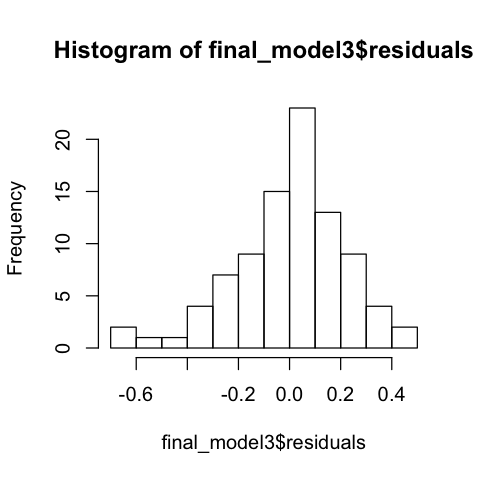

In [216]:
options(repr.plot.width=4, repr.plot.height=4)
hist(final_model3$residuals, breaks = 10)